## Data

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision.transforms import ToTensor

training_data = torchvision.datasets.MNIST(root='./data', transform=ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)

In [3]:
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [4]:
X_training, Y_training = next(iter(training_dataloader))
X_training.shape, Y_training.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [5]:
X_test, Y_test = next(iter(test_dataloader))
X_test.shape, Y_test.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [6]:
X_training = X_training.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_training.shape, Y_training.shape, X_test.shape, Y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [7]:
X_training_subset = torch.cat([X_training[Y_training==0], X_training[Y_training==1]])
Y_training_subset = torch.cat([Y_training[Y_training==0], Y_training[Y_training==1]])
X_test_subset = torch.cat([X_test[Y_test==0], X_test[Y_test==1]])
Y_test_subset = torch.cat([Y_test[Y_test==0], Y_test[Y_test==1]])
X_training_subset.shape, Y_training_subset.shape, X_test_subset.shape, Y_test_subset.shape

(torch.Size([12665, 784]),
 torch.Size([12665]),
 torch.Size([2115, 784]),
 torch.Size([2115]))

In [8]:
from sklearn.model_selection import train_test_split

X_train_large, X_val, Y_train_large, Y_val = train_test_split(X_training, Y_training, test_size=1000)
X_train, X_dummy, Y_train, Y_dummy = train_test_split(X_train_large, Y_train_large, train_size=1000)

# X_train, X_val, Y_train, Y_val = train_test_split(X_training_subset, Y_training_subset, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([1000, 784]),
 torch.Size([1000, 784]),
 torch.Size([1000]),
 torch.Size([1000]))

## NN

In [9]:
device = 'cpu'

In [10]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train.unsqueeze(1).type(torch.float32), batch_size=32, shuffle=True), make_dataloader(X_val, Y_val.unsqueeze(1).type(torch.float32), batch_size=32)

In [11]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=784, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=1),
        )
    
    def forward(self, x):
        return self.layers(x)


In [12]:
from torchinfo import summary

summary(
    model=SimpleNN(),
    input_size=(32, 784),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
SimpleNN                                 [32, 784]            [32, 1]              --                   True
├─Sequential: 1-1                        [32, 784]            [32, 1]              --                   True
│    └─Linear: 2-1                       [32, 784]            [32, 100]            78,500               True
│    └─ReLU: 2-2                         [32, 100]            [32, 100]            --                   --
│    └─Linear: 2-3                       [32, 100]            [32, 100]            10,100               True
│    └─ReLU: 2-4                         [32, 100]            [32, 100]            --                   --
│    └─Linear: 2-5                       [32, 100]            [32, 1]              101                  True
Total params: 88,701
Trainable params: 88,701
Non-trainable params: 0
Total mult-adds (M): 2.84
Input size (MB): 0.10
Forward/b

In [13]:
model_nn = SimpleNN().to(device)

In [14]:
from scripts.metrics import NegMeanSquaredError

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_nn.parameters())
metric = NegMeanSquaredError()

In [15]:
from scripts.train import train_model

history = train_model(
    model=model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    device=device
)

Training model for 500 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 13.132707, Train score: -13.132707, Val loss: 6.882002, Val score: -6.882002
Epoch: 2 => Train loss: 5.364226, Train score: -5.364226, Val loss: 4.585585, Val score: -4.585585
Epoch: 3 => Train loss: 4.352152, Train score: -4.352152, Val loss: 4.342611, Val score: -4.342611
Epoch: 4 => Train loss: 3.756452, Train score: -3.756452, Val loss: 4.003564, Val score: -4.003564
Epoch: 5 => Train loss: 3.368073, Train score: -3.368073, Val loss: 3.854403, Val score: -3.854403
Epoch: 6 => Train loss: 3.095806, Train score: -3.095806, Val loss: 3.609177, Val score: -3.609177
Epoch: 7 => Train loss: 2.768047, Train score: -2.768047, Val loss: 3.501203, Val score: -3.501203
Epoch: 8 => Train loss: 2.476190, Train score: -2.476190, Val loss: 3.365510, Val score: -3.365510
Epoch: 9 => Train loss: 2.363583, Train score: -2.363583, Val loss: 3.461792, Val score: -3.461792
Epoch: 10 => Train loss: 2.205264, Train score: 

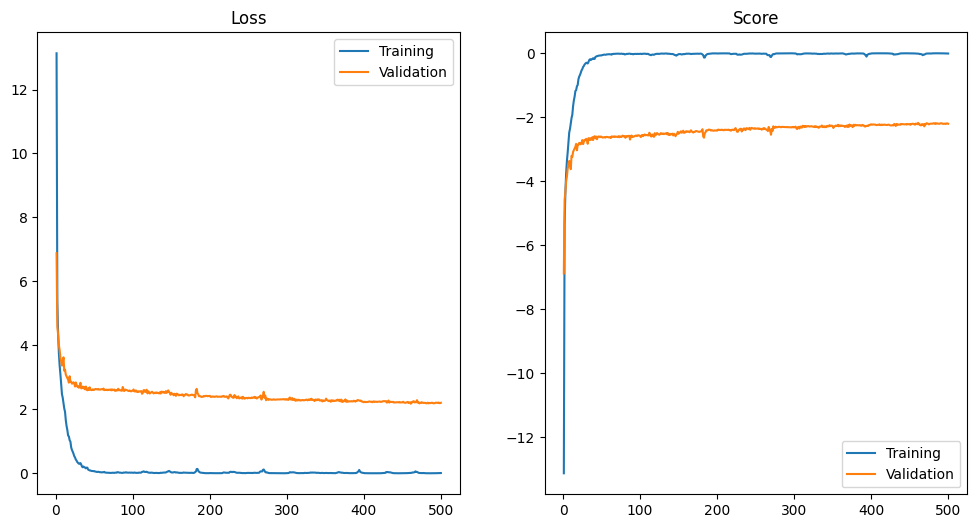

In [16]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [17]:
from scripts.test import predict

preds_train, preds_val = predict(model_nn, X_train, device), predict(model_nn, X_val, device)
score_train, score_val = metric(preds_train, Y_train.unsqueeze(1)), metric(preds_val, Y_val.unsqueeze(1))
score_train, score_val

(tensor(-0.0076), tensor(-2.2260))

In [18]:
preds_nn = predict(model_nn, X_test_subset, device)
score_test = metric(preds_nn, Y_test_subset.unsqueeze(1))
score_test

tensor(-1.6308)

## SVM with NTK

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
from sklearn.svm import SVR

In [24]:
from scripts.ntk import NTK

### T = 0

In [25]:
ntk_init = NTK(SimpleNN().to(device))

In [26]:
model_km_init = SVR(kernel=ntk_init.get_ntk)

In [27]:
model_km_init.fit(X_train, Y_train)

SVR(kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f18f289db40>>)

In [28]:
preds_train, preds_val = model_km_init.predict(X_train), model_km_init.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(1.1261925392932073, 2.7263906828178643)

In [29]:
preds_km_init = model_km_init.predict(X_test_subset)
score_test = mean_squared_error(Y_test_subset, preds_km_init)
score_test

2.518604150985001

### T = inf

In [30]:
ntk_inf = NTK(model_nn)

In [31]:
model_km_inf = SVR(kernel=ntk_inf.get_ntk)

In [32]:
model_km_inf.fit(X_train, Y_train)

SVR(kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f18cf72d3f0>>)

In [33]:
preds_train, preds_val = model_km_inf.predict(X_train), model_km_inf.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(0.005383524124056348, 2.2894372676754187)

In [34]:
preds_km_inf = model_km_inf.predict(X_test_subset)
score_test = mean_squared_error(Y_test_subset, preds_km_inf)
score_test

1.6167503454901546

## Plot

In [35]:
preds_nn.shape, preds_km_init.shape, preds_km_inf.shape

(torch.Size([2115, 1]), (2115,), (2115,))

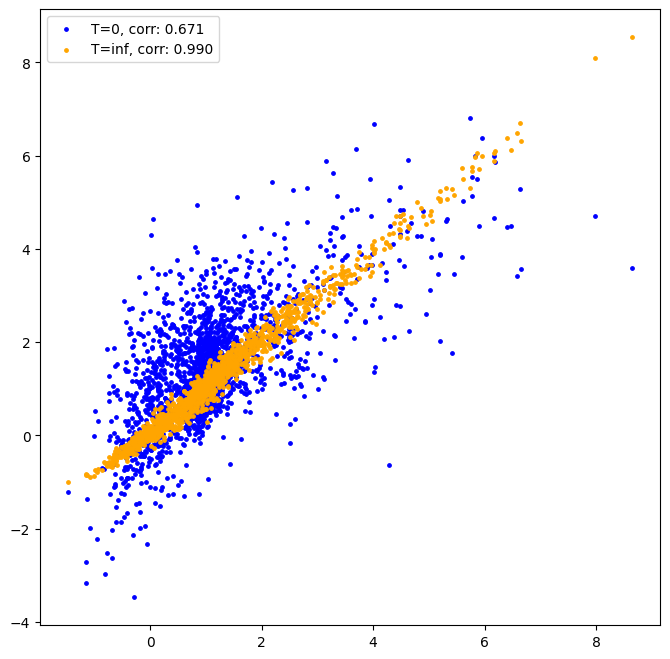

In [36]:
from scripts.utils import plot_ntk_corrs

plot_ntk_corrs(preds_nn, preds_km_init, preds_km_inf)